# Weight plots

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
np.random.seed(1234)

import sys
sys.path.append("../src")
from utils import data as udata
from utils import dists as udists
from utils import misc as u
from truth import mask_truths
from predictors import make_predictor
import losses
from pymmwr import Epiweek
from tqdm import tqdm, trange
import ledge.merge as merge
import ledge.update as update
from functools import partial
import json
import os.path as path
import inspect
import viz

In [2]:
EXP_DIR = "../data/processed/cdc-flusight-ensemble/"
OUTPUT_DIR = "../models/cdc-flusight-ensemble/"
TARGET = "4-ahead"
MAX_LAG = 29
REGIONS = ["nat", *[f"hhs{i}" for i in range(1, 11)]]
TESTING_SEASONS = list(range(2014, 2017))

LOSS_FN = losses.ploss
MERGE_FN = merge.latest

SEASON = 2014
REGION = "nat"

In [3]:
components = [udata.Component(EXP_DIR, m) for m in udata.available_models(EXP_DIR)]
ad = udata.ActualData(EXP_DIR)

In [4]:
def plot(ax, predictor, region, season):
    """
    Plot weight movement graph for the predictor
    """
    
    first_losses = []
    final_losses = []

    truths = [ad.get(TARGET, region, season, lag=l) for l in range(MAX_LAG + 1)]
    c_preds = [cmp.get(TARGET, region, season) for cmp in components]

    first_truth = merge.earliest(truths)
    final_truth = merge.latest(truths)
    pred, weights_history = predictor(truths, c_preds)
    
    first_losses.append(float(LOSS_FN(pred, first_truth).mean()))
    final_losses.append(float(LOSS_FN(pred, final_truth).mean()))
    
    mat = xr.merge([h.rename(idx)
                    for idx, h in enumerate(weights_history)]).to_array().values.T
    models = list(weights_history[0].model.values)
    epiweeks = [np.asscalar(ew.values) for ew in pred.epiweek]
    xticklabels = [f"{ew.year * 100 + ew.week}" for ew in epiweeks]
    viz.gh_heatmap(ax, mat, xticklabels, models)

    return {
        "first_loss": np.mean(first_losses),
        "final_loss": np.mean(final_losses)
    }

## Individuals

{'final_loss': 0.9522419986691897, 'first_loss': 0.9531472204570685}

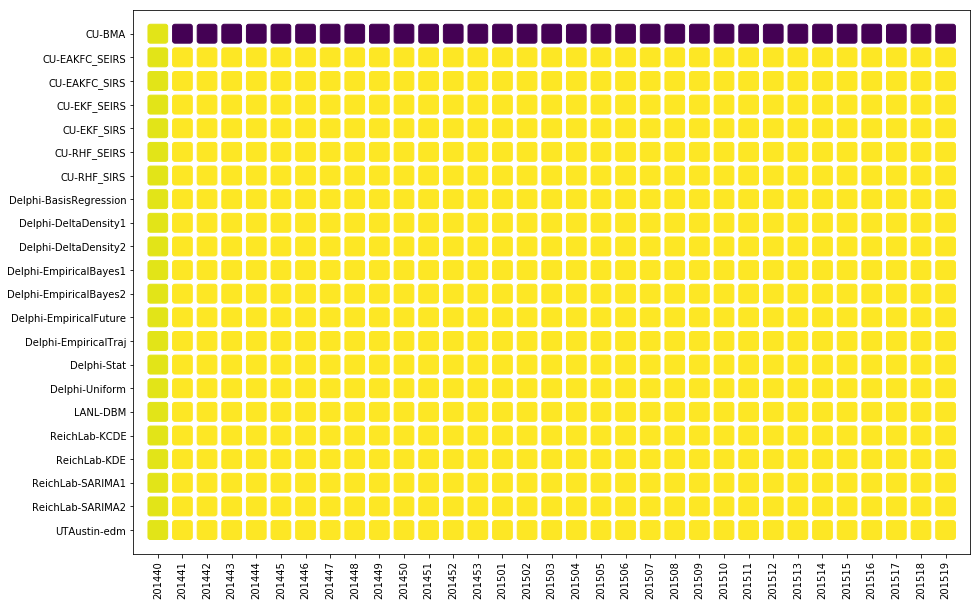

In [5]:
# Sanity check
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
update_fn = partial(update.pick, index=0)
plot(axes, make_predictor(LOSS_FN, MERGE_FN, update_fn), REGION, SEASON)

## Mean

{'final_loss': 0.9253868287420758, 'first_loss': 0.9297074952347303}

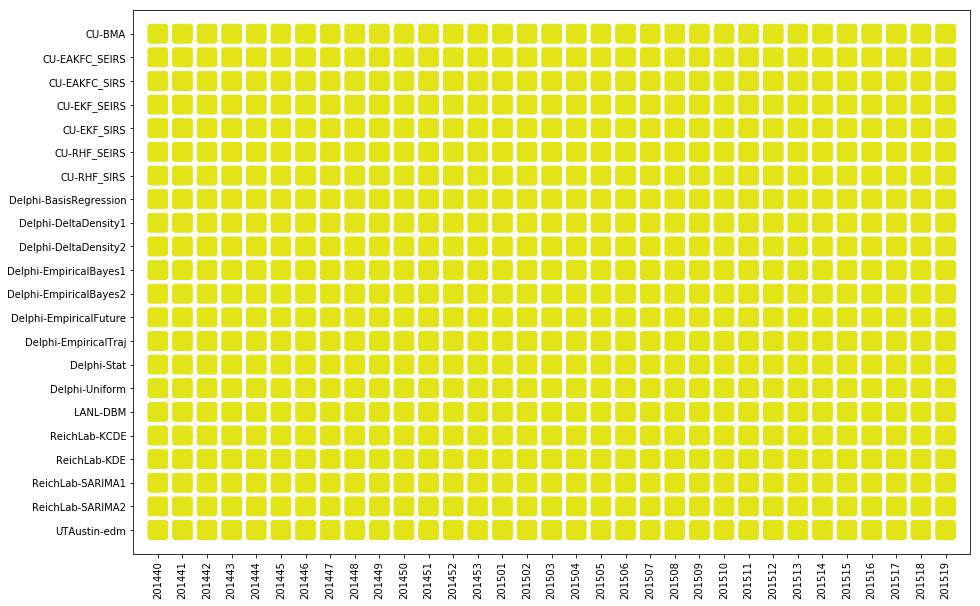

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
plot(axes, make_predictor(LOSS_FN, MERGE_FN, update.noop), REGION, SEASON)

## Dem

{'final_loss': 0.9066560176798648, 'first_loss': 0.9091756187310481}

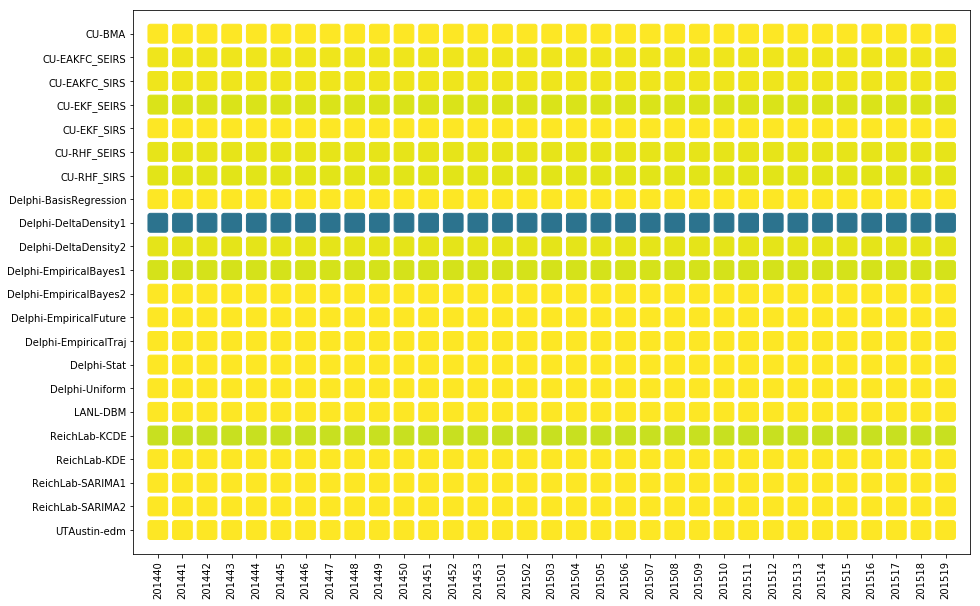

In [7]:
# Load the weights from DEM training done in tracking-ensemble repository
with open(path.join(OUTPUT_DIR, TARGET, "dem-weight-ensemble.json")) as fp:
    w_vec = json.load(fp)["fit_params"]["weights"]
    models = [cmp.name for cmp in components]
    weights = xr.DataArray(w_vec, dims="model", coords={ "model": models })
    
update_fn = partial(update.noop, init_weights=weights)
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
plot(axes, make_predictor(LOSS_FN, MERGE_FN, update_fn), REGION, SEASON)

## Follow the leader

{'final_loss': 0.8748081175830515, 'first_loss': 0.902283006885351}

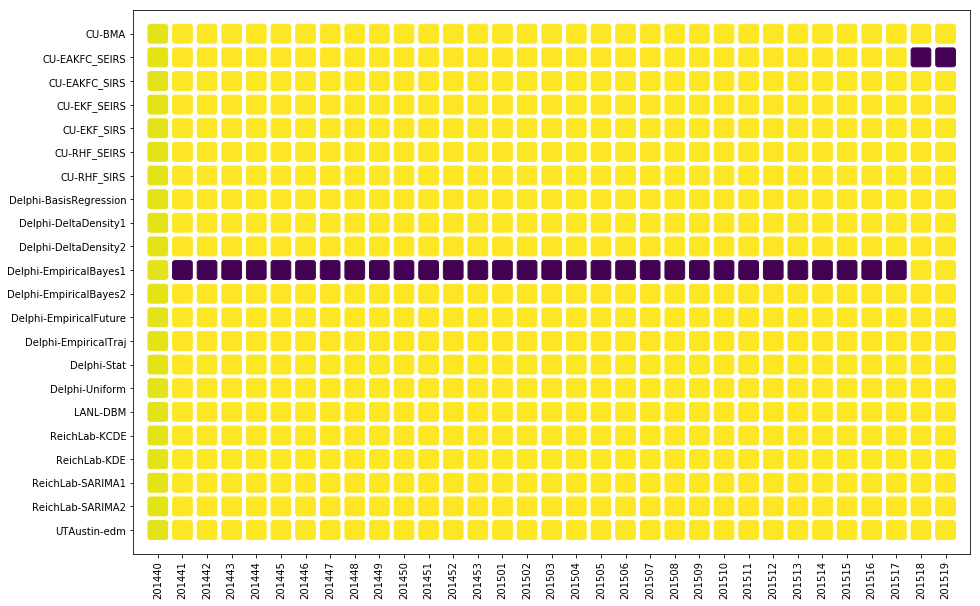

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
plot(axes, make_predictor(LOSS_FN, MERGE_FN, update.ftl), REGION, SEASON)

## MW

{'final_loss': 0.8964578612369241, 'first_loss': 0.9241715392322896}

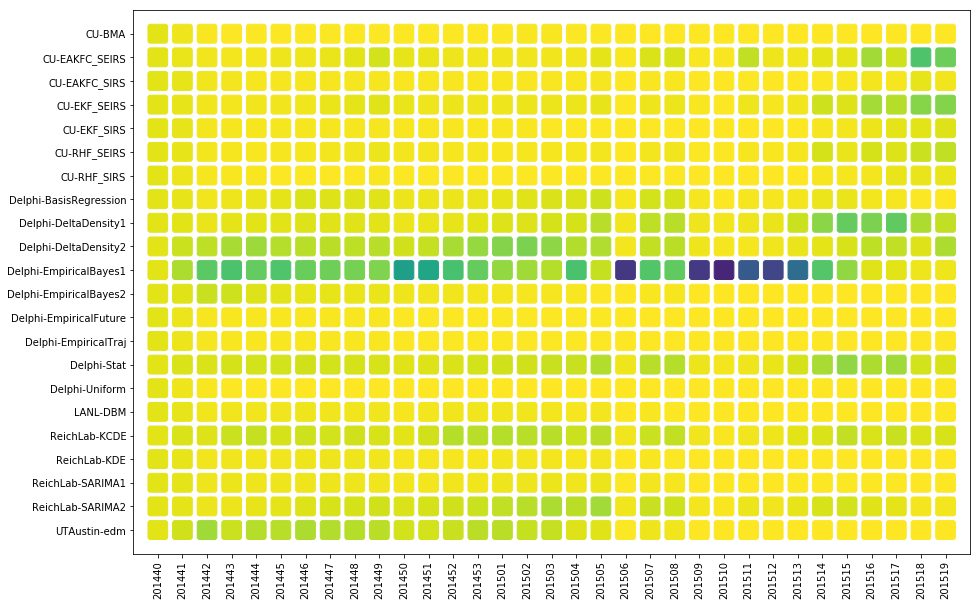

In [9]:
update_fn = partial(update.mw, eta=0.9)
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
plot(axes, make_predictor(LOSS_FN, MERGE_FN, update_fn), REGION, SEASON)

## Hedge

{'final_loss': 0.8745722593486932, 'first_loss': 0.9024360591858944}

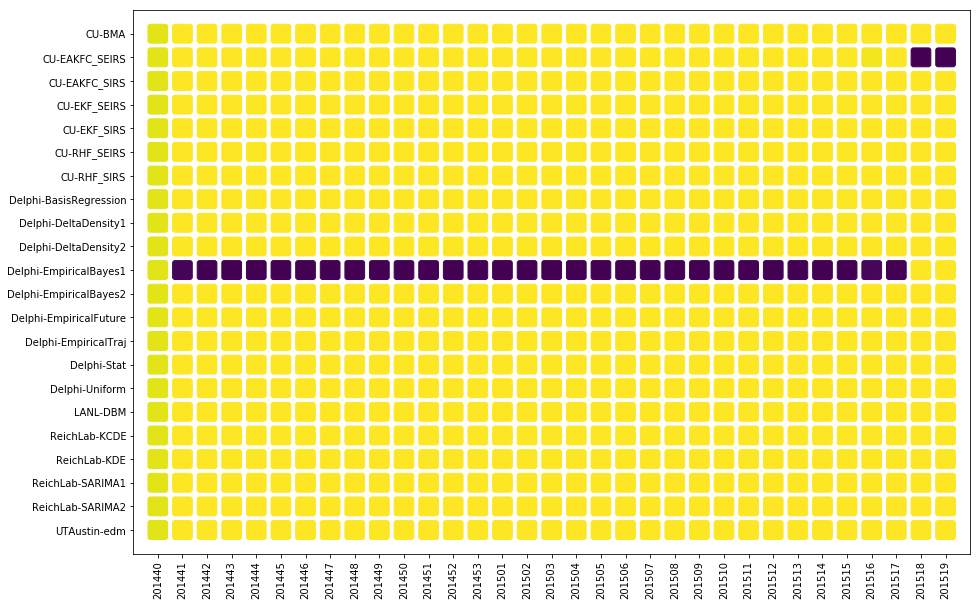

In [10]:
update_fn = partial(update.hedge, eta=24.1)
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
plot(axes, make_predictor(LOSS_FN, MERGE_FN, update_fn), REGION, SEASON)

## Fixed share

{'final_loss': 0.8691301936445003, 'first_loss': 0.8989068837959224}

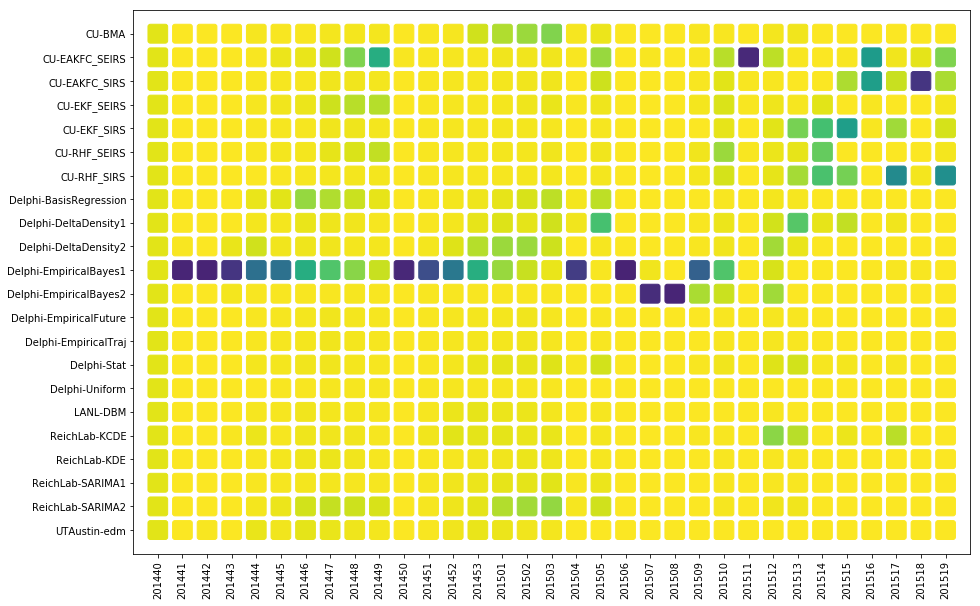

In [11]:
update_fn = partial(update.fixed_share, eta=24.1, alpha=0.1)
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
plot(axes, make_predictor(LOSS_FN, MERGE_FN, update_fn), REGION, SEASON)